In [106]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import rankdata

from SSLTree import SSLTree


def encontrar_fila_con_palabra(ruta_archivo, palabra):
    with open(ruta_archivo, 'r') as archivo:
        for num_linea, linea in enumerate(archivo, 1):
            if palabra in linea:
                return num_linea
    return -1


def cargar_fold(p_unlabeled, name, k):
    train_data = pd.read_csv(
        f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
        header=None,
        skiprows=encontrar_fila_con_palabra(
            f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
            '@data'))

    test_data = pd.read_csv(
        f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
        header=None,
        skiprows=encontrar_fila_con_palabra(
            f'../datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
            '@data'))

    columnas_strings = train_data.iloc[:, :-1].select_dtypes(exclude=['number']).columns.tolist()

    for col in columnas_strings:
        encoder = LabelEncoder()
        train_data.iloc[:, col] = encoder.fit_transform(train_data.iloc[:, col])
        train_data[col] = train_data[col].apply(pd.to_numeric)
        test_data.iloc[:, col] = encoder.transform(test_data.iloc[:, col])
        test_data[col] = test_data[col].apply(pd.to_numeric)

    if pd.api.types.is_numeric_dtype(test_data.iloc[:, -1]):
        train_data.loc[train_data.iloc[:, -1] == ' unlabeled', len(train_data.columns) - 1] = -1
        train_data.iloc[:, -1] = pd.to_numeric(train_data.iloc[:, -1])
    else:
        label_encoder = LabelEncoder()
        # Codificar las etiquetas de clase
        train_data.iloc[:, -1] = label_encoder.fit_transform(train_data.iloc[:, -1])
        train_data.loc[train_data.iloc[:, -1] == label_encoder.transform([' unlabeled'])[0], len(
            train_data.columns) - 1] = -1

        test_data.iloc[:, -1] = label_encoder.transform(test_data.iloc[:, -1])

    train_data[train_data.columns[-1]] = train_data[train_data.columns[-1]].astype(int)
    test_data[test_data.columns[-1]] = test_data[test_data.columns[-1]].astype(int)

    train_data_label = train_data[train_data.iloc[:, -1] != -1]

    return train_data, test_data, train_data_label


def cross_val(name, p_unlabeled="20"):
    accuracy_ssl = []
    accuracy_dt = []
    accuracy_st = []

    print("PERCENTAGE:", p_unlabeled, "- DATASET:", name)

    w_values = np.arange(0, 1.01, 0.01)

    best_w = None
    best_score = 0

    for w in w_values:
        run_scores = []

        for k in range(1, 11):
            train_data, test_data, train_data_label = cargar_fold(p_unlabeled, name, k)

            my_tree = SSLTree(w=w)
            my_tree.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)

            run_scores.append(
                accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))

        avg_score = np.mean(run_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_w = w

    print(f'Mejor w: {best_w} con accuracy: {best_score}')

    for k in range(1, 11):
        train_data, test_data, train_data_label = cargar_fold(p_unlabeled, name, k)

        my_tree = SSLTree(w=best_w)
        my_tree.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)
        # print(my_tree.export_tree())
        # print(accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))

        dt = DecisionTreeClassifier()
        dt.fit(train_data_label.iloc[:, :-1].values, train_data_label.iloc[:, -1].values)
        # print(export_text(dt))
        # print(accuracy_score(test_data.iloc[:, -1].values, dt.predict(test_data.iloc[:, :-1].values)))

        self_training_model = SelfTrainingClassifier(DecisionTreeClassifier())
        self_training_model.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)

        accuracy_ssl.append(
            accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))
        accuracy_dt.append(accuracy_score(test_data.iloc[:, -1].values, dt.predict(test_data.iloc[:, :-1].values)))
        accuracy_st.append(accuracy_score(test_data.iloc[:, -1].values,
                                          self_training_model.predict(test_data.iloc[:, :-1].values)))
        print("\tFOLD", k, "- Done")

    return np.median(accuracy_ssl), np.median(accuracy_dt), np.median(accuracy_st)


def estudio_w(name):
    accuracies_ssl = []

    w_values = np.arange(0, 1.1, 0.1)

    for i, p_unlabeled in enumerate(["10", "20", "30", "40"]):
        acc = []
        for w in w_values:
            run_scores = []

            for k in range(1, 11):
                train_data, test_data, train_data_label = cargar_fold(p_unlabeled, name, k)

                my_tree = SSLTree(w=w)
                my_tree.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)

                run_scores.append(
                    accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))

            acc.append(np.mean(run_scores))
        
        accuracies_ssl.append(acc)
        print(p_unlabeled, "- DONE")

    return np.array(accuracies_ssl)


def plot_estudio_w_expandido(accuracies, name):
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.xlim(0, 40)
    ax.set_xticks([0, 10, 20, 30])
    ax.set_xticklabels(['10%', '20%', '30%', '40%'])

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 26, 27,
         28, 29, 30, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
        , np.ravel(accuracies), marker='o', markerfacecolor='none', linestyle='-', color='red', markersize=8, linewidth=1)

    plt.axvline(x=10, color='g', linestyle='-.')
    plt.axvline(x=20, color='g', linestyle='-.')
    plt.axvline(x=30, color='g', linestyle='-.')

    ax2 = ax.twiny()

    ws = ['.0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1/0',
          '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1/0',
          '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1/0',
          '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1']

    ax2.set_xticks(np.arange(0, 41, 1))
    ax2.set_xticklabels(ws)

    ax.set_xlabel('Porcentaje de etiquetados')
    ax.set_ylabel('Accuracy (media 10 folds)')
    ax2.set_xlabel('Parámetro peso (w)')

    plt.title("Efecto del parámetro w en el Dataset " + name, pad=15)
    plt.show()


def plot_estudio_w(accuracies, name):
    accuracies = np.ravel(accuracies)
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.xlim(0, 10)
    plt.ylim(min(accuracies) - 0.03, math.ceil((max(accuracies) + 0.01) * 100) / 100)

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        , accuracies[0:11], marker='o', markerfacecolor='none', linestyle='-', color='green', markersize=8, linewidth=1,
        label="10%")

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        , accuracies[11:22], marker='o', markerfacecolor='none', linestyle='-', color='blue', markersize=8, linewidth=1,
        label="20%")

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        , accuracies[22:33], marker='o', markerfacecolor='none', linestyle='-', color='red', markersize=8, linewidth=1,
        label="30%")

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        , accuracies[33:44], marker='o', markerfacecolor='none', linestyle='-', color='purple', markersize=8,
        linewidth=1, label="40%")

    ws = ['.0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1']

    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_xticklabels(ws)

    ax.set_xlabel('Parámetro peso (w)')
    ax.set_ylabel('Accuracy (media 10 folds)')
    ax.legend(title='Porcentaje \nde etiquetados', loc='best', fontsize='small')

    plt.title("Efecto del parámetro w en el Dataset " + name, pad=15)
    plt.margins(0)
    plt.show()

# Estudio del parámetro w

Previsiblemente, el parámetro w es muy dependiente del propio dataset. Relacionado del mismo modo con las suposiciones del aprendizaje Semi-Supervisado (en algún caso, SSLTree no mejorará un modelo supervisado).

In [92]:
accuracies_wine = estudio_w("wine")

10 - DONE
20 - DONE
30 - DONE
40 - DONE


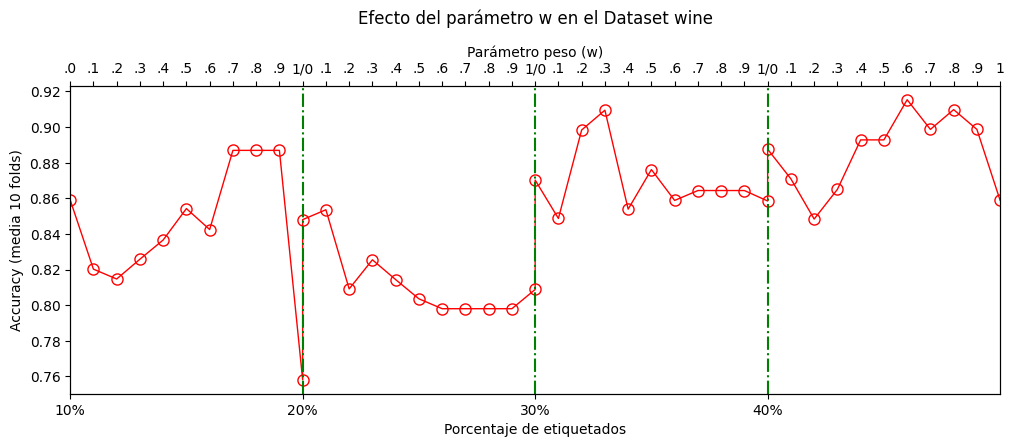

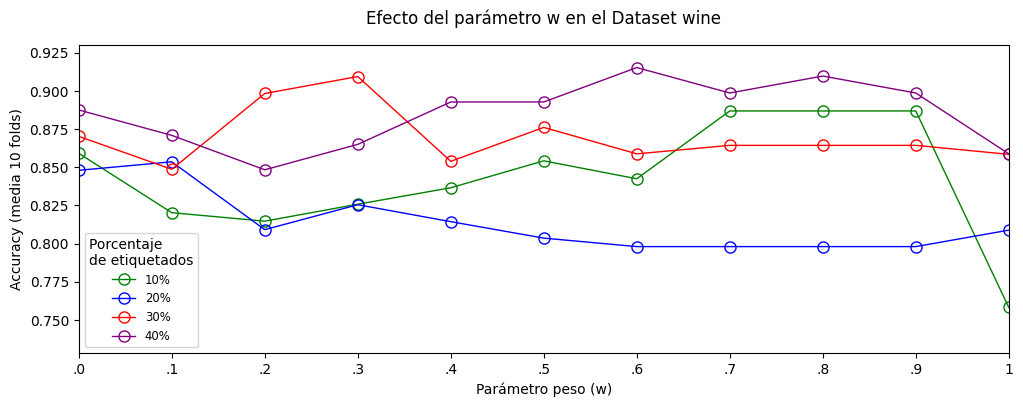

In [95]:
plot_estudio_w_expandido(accuracies_wine, "wine")
plot_estudio_w(accuracies_wine, "wine")

In [ ]:
accuracies_tae = estudio_w("tae")

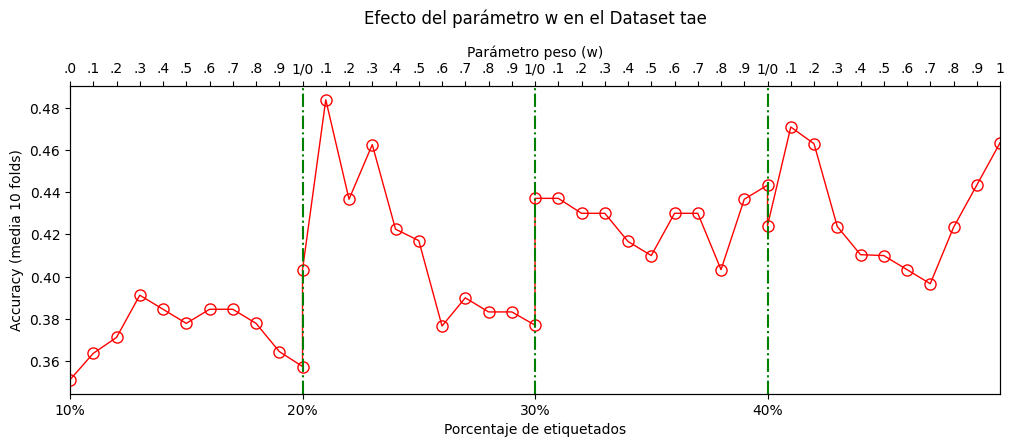

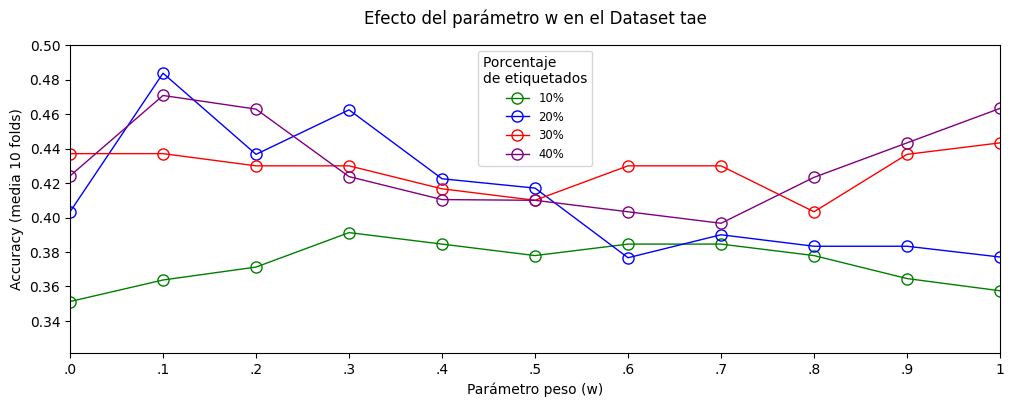

In [97]:
plot_estudio_w_expandido(accuracies_tae, "tae")
plot_estudio_w(accuracies_tae, "tae")

Tal y como los autores indicaron, el parámetro resulta ser muy dependiente del conjunto de datos.

Estos resultados indican:
- El parámetro w es beneficioso y **podría** mejorar el rendimiento del modelo con la salvedad de que, previsiblemente, para aquellos conjuntos de datos que no cumplan las suposiciones del semi-supervisado, el mejor modelo será un supervisado (parámetro w = 1).
- El porcentaje de etiquetados tiene un papel muy importante.
- Será necesario establecer un parámetro w personalizado para cada conjunto de datos.

In [81]:
names = [
    # "abalone",
    "appendicitis",
    "australian",
    # "automobile",
    # "banana", best_left (puede ser porque tiene -1 en las etiquetas)
    # "breast",
    "bupa",
    # "chess",
    "cleveland",
    "coil2000",
    "contraceptive",
    # crx",
    "dermatology",
    "ecoli",
    "flare",
    "german",
    "glass",
    "haberman",
    "heart",
    "hepatitis",
    # "housevotes",
    "iris",
    "led7digit",
    # "lymphography",
    # "magic", tarda mucho
    "mammographic",
    "marketing",
    "monk-2",
    "movement_libras",
    # "mushroom",
    "nursery",
    "page-blocks",
    "penbased",
    "phoneme",
    # "pima",
    # "ring", no hay problema, pero tarda como dos milenios (aprox)
    "saheart",
    "satimage",
    "segment",
    "sonar",
    "spambase",
    "spectfheart",
    # "splice",
    "tae",
    # "texture", no hay problema, pero tarda como tres milenios (aprox)
    "thyroid",
    "tic-tac-toe",
    # "titanic", tiene -1 en las etiquetas
    "twonorm",
    "vehicle",
    "vowel",
    "wine",
    "wisconsin",
    "yeast",
    "zoo"
]

names = ["iris", "appendicitis", "zoo"]

# Experimentación parámetro w para cada dataset

In [140]:
def w_heatmap(matrix, less_better=False):
    w_labels = ['1', '.9', '.8', '.7', '.6', '.5', '.4', '.3', '.2', '.1', '.0']
    percentage = ["10%", "20%", "30%", "40%"]

    plt.figure(figsize=(4, 5))  # Tamaño ajustado
    sns.heatmap(np.flip(matrix, axis=0), cmap='Blues' if less_better else 'Blues_r' ,linewidths=0.5, annot=True, annot_kws={"size": 10}, 
                xticklabels=percentage, yticklabels=w_labels)

    plt.title('Estudio de w')
    plt.ylabel('Parámetro w')
    plt.xlabel('Porcentaje de etiquetados')
    
    plt.show()
    
    plt.show()

In [82]:
all_matrix = []
for name in names:
    all_matrix.append(estudio_w(name).T)

10 - DONE
20 - DONE
30 - DONE
40 - DONE
10 - DONE
20 - DONE
30 - DONE
40 - DONE
10 - DONE
20 - DONE
30 - DONE
40 - DONE


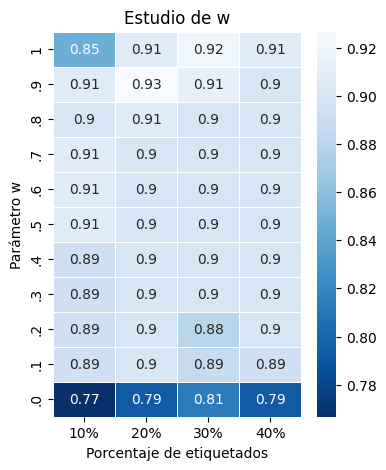

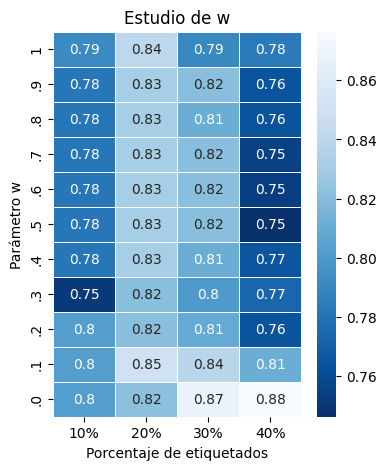

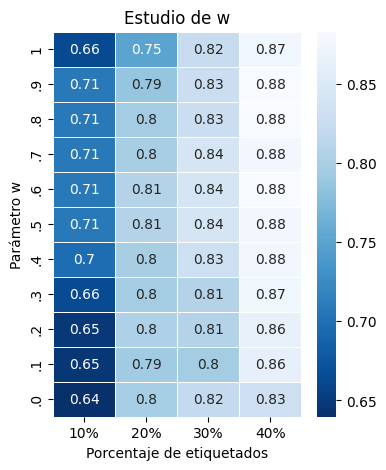

In [141]:
for a in all_matrix:
    w_heatmap(a)

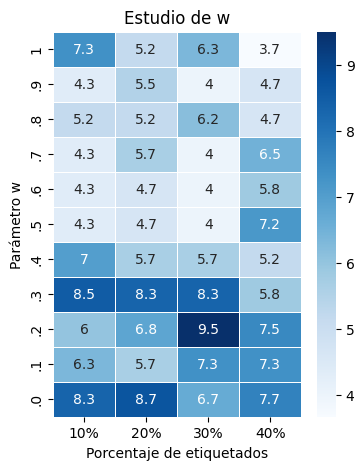

In [142]:
rankings = []
for matrix in all_matrix:
    rankings.append(rankdata(-matrix, axis=0))

w_heatmap(np.mean(rankings, axis=0), less_better=True)

# Comparativa entre SSLTree, DT y SelfTraining

In [116]:
all_medians = {}

all_mean_rankings = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    medians_ssl = []
    medians_dt = []
    medians_st = []
    for name in names:
        m_ssl, m_dt, m_st = cross_val(name, p)
        # break
        medians_ssl.append(m_ssl)
        medians_dt.append(m_dt)
        medians_st.append(m_st)
    # break
    print(medians_ssl)
    print(medians_dt)
    print(medians_st)

    all_medians[p] = np.stack((medians_ssl, medians_dt, medians_st))

    rankings = rankdata(-all_medians[p], method="average", axis=0)
    print(rankings)

    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

final_rankings = rankdata(all_mean_rankings, method="average", axis=0)
print(all_mean_rankings)

PERCENTAGE: 10 - DATASET: appendicitis
Mejor w: 0.1 con accuracy: 0.801818181818182
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: iris
Mejor w: 0.5 con accuracy: 0.9066666666666666
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
[0.8181818181818182, 0.9333333333333333]
[0.7727272727272727, 0.9666666666666667]
[0.7636363636363637, 0.9333333333333333]
[[1.  2.5]
 [2.  1. ]
 [3.  2.5]]
PERCENTAGE: 20 - DATASET: appendicitis
Mejor w: 0.1 con accuracy: 0.85
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 20 - DATASET: iris
Mejor w: 0.9 con accuracy: 0.9266666666666665
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 

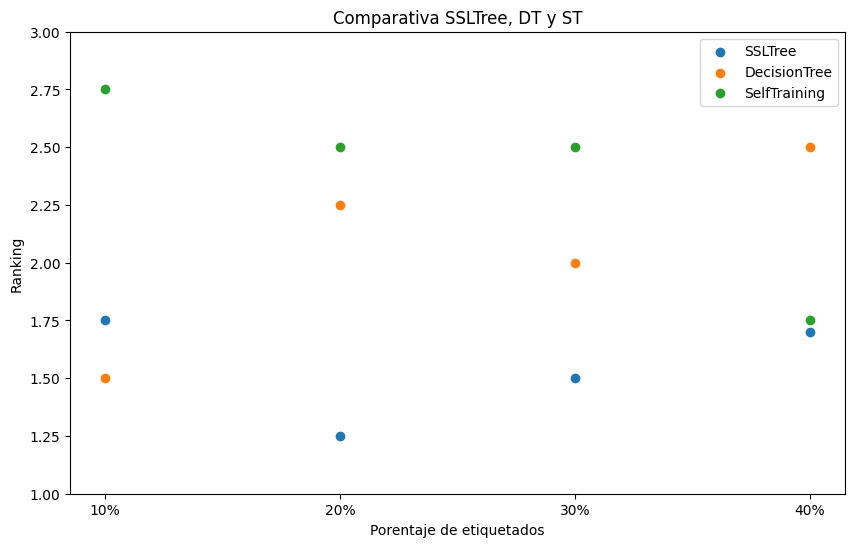

In [117]:
plt.figure(figsize=(10, 6))

for i, percentage in enumerate(["10%", "20%", "30%", "40%"]):
    top = all_mean_rankings[:, i].copy()
    uniques, _ = np.unique(top, return_counts=True)

    displacement = 0.05 * np.linspace(-1, 1, len(uniques), endpoint=False)
    dup = 0
    for j, value in enumerate(top):
        if np.count_nonzero(top == value) > 1:
            all_mean_rankings[j][i] += displacement[dup] if dup < len(displacement) else 0
            dup += 1

classifiers = ["SSLTree", "DecisionTree", "SelfTraining"]
for j, classifier in enumerate(classifiers):
    plt.scatter(["10%", "20%", "30%", "40%"], all_mean_rankings[j], label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa SSLTree, DT y ST")

plt.legend()
plt.show()

Ranks promedio: 0    7.366667
1    7.333333
2    5.966667
3    5.133333
4    3.333333
5    3.100000
6    2.333333
7    1.433333
dtype: float64


C:\Users\dmacha\Documents\TFM-VIU\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


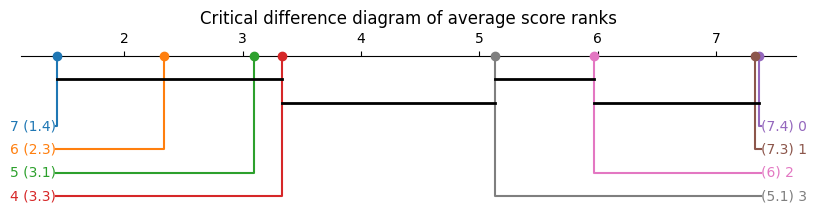

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

# Supongamos que estos son los resultados de los clasificadores en diferentes datasets
# Filas: Datasets
# Columnas: Clasificadores
np.random.default_rng(1)
dict_data = {
    'model1': np.random.normal(loc=0.2, scale=0.1, size=30),
    'model2': np.random.normal(loc=0.2, scale=0.1, size=30),
    'model3': np.random.normal(loc=0.4, scale=0.1, size=30),
    'model4': np.random.normal(loc=0.5, scale=0.1, size=30),
    'model5': np.random.normal(loc=0.7, scale=0.1, size=30),
    'model6': np.random.normal(loc=0.7, scale=0.1, size=30),
    'model7': np.random.normal(loc=0.8, scale=0.1, size=30),
    'model8': np.random.normal(loc=0.9, scale=0.1, size=30),
}

data_list = [dict_data[key] for key in dict_data]

results = np.array(data_list).T

nemenyi_result = sp.posthoc_nemenyi_friedman(results)

ranks = np.mean(pd.DataFrame(-results).rank(axis=1, method='average'), axis=0)
print("Ranks promedio:", ranks)

plt.figure(figsize=(10, 2), dpi=100)

plt.title('Critical difference diagram of average score ranks')

sp.critical_difference_diagram(ranks, nemenyi_result)
plt.show()

In [24]:
rankdata(np.stack(([0,1], [2,3], [4,5]))
, method="average", axis=0)

array([[1., 1.],
       [2., 2.],
       [3., 3.]])